https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data

In [4]:
from kaggle.api.kaggle_api_extended import KaggleApi

In [5]:
api = KaggleApi()

In [6]:
api.authenticate()

In [9]:
api.competition_download_file('sentiment-analysis-on-movie-reviews',
                             'test.tsv.zip',
                              path='./'
                             )
api.competition_download_file('sentiment-analysis-on-movie-reviews',
                             'train.tsv.zip',
                              path='./'
                             )

test.tsv.zip: Skipping, found more recently modified local copy (use --force to force download)


100%|██████████| 1.28M/1.28M [00:01<00:00, 688kB/s]

In [10]:
import zipfile

In [11]:
with zipfile.ZipFile('./test.tsv.zip', 'r') as zipref:
    zipref.extractall('./')

In [12]:
with zipfile.ZipFile('./train.tsv.zip', 'r') as zipref:
    zipref.extractall('./')

# preprocess

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('train.tsv', sep='\t') 
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [3]:
df = df.drop_duplicates(subset=['SentenceId'], keep='first')

<AxesSubplot:>

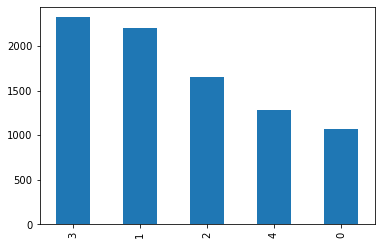

In [4]:
df['Sentiment'].value_counts().plot(kind='bar')

In [5]:
len(df)

8529

0 - negative
1 - somewhat negative
2 - neutral
3 - somewhat positive
4 - positive

In [161]:
seq_len = 32
num_samples = len(df)

num_samples, seq_len

(8529, 32)

In [162]:
from transformers import BertTokenizer

In [163]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [164]:
tokens = tokenizer(df['Phrase'].tolist(), max_length=seq_len,
                  truncation=True, padding='max_length',
                  add_special_tokens=True,
                  return_tensors='np')

In [165]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [166]:
tokens['input_ids']

array([[ 101,  138, 1326, ..., 5411, 1821,  102],
       [ 101, 1188, 3589, ...,    0,    0,    0],
       [ 101, 2431, 3899, ...,    0,    0,    0],
       ...,
       [ 101,  118,  149, ...,    0,    0,    0],
       [ 101, 1109, 2523, ...,    0,    0,    0],
       [ 101, 1109, 1273, ..., 2897,  119,  102]])

In [167]:
tokens['attention_mask']

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1]])

In [168]:
import numpy as np

with open('movie-xids.npy', 'wb') as f:
    np.save(f, tokens['input_ids'])
    
with open('movie-xmask.npy', 'wb') as f:
    np.save(f, tokens['attention_mask'])

In [169]:
arr = df['Sentiment'].values

In [170]:
arr.shape

(8529,)

In [171]:
arr.max()+1

5

In [172]:
arr

array([1, 4, 1, ..., 1, 1, 2], dtype=int64)

In [173]:
labels = np.zeros((num_samples, arr.max()+1))
labels.shape

(8529, 5)

In [174]:
labels[np.arange(num_samples), arr] = 1

In [175]:
labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [176]:
with open('movie-labels.npy', 'wb') as f:
    np.save(f, labels)

# input pipeline

In [177]:
import numpy as np

In [178]:
with open('movie-xids.npy', 'rb') as f:
    Xids = np.load(f, allow_pickle=True)
    
with open('movie-xmask.npy', 'rb') as f:
    Xmask = np.load(f, allow_pickle=True)
    
with open('movie-labels.npy', 'rb') as f:
    labels = np.load(f, allow_pickle=True)

In [179]:
Xids.shape

(8529, 32)

In [180]:
import tensorflow as tf

In [181]:
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

In [182]:
dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(32,), dtype=tf.int32, name=None), TensorSpec(shape=(32,), dtype=tf.int32, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [183]:
len(dataset)

8529

In [184]:
def map_func(input_ids, attention_mask, labels):
    return ({'input_ids': input_ids,
            'attention_mask': attention_mask}, labels)

In [185]:
dataset = dataset.map(map_func)

In [186]:
dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(32,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(32,), dtype=tf.int32, name=None)}, TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [187]:
batch_size = 16

In [188]:
dataset = dataset.shuffle(1000).batch(batch_size, drop_remainder=True)

In [189]:
dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 32), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(16, 32), dtype=tf.int32, name=None)}, TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))>

In [190]:
len(dataset)

533

In [191]:
split = 0.9

In [192]:
size = int((Xids.shape[0] / batch_size) * split)

In [193]:
size

479

In [194]:
train_ds = dataset.take(size)
val_ds = dataset.skip(size)

In [195]:
len(val_ds)

54

In [196]:
tf.data.experimental.save(train_ds, 'train')
tf.data.experimental.save(val_ds, 'val')

In [197]:
train_ds.element_spec

({'input_ids': TensorSpec(shape=(16, 32), dtype=tf.int32, name=None),
  'attention_mask': TensorSpec(shape=(16, 32), dtype=tf.int32, name=None)},
 TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))

In [198]:
val_ds.element_spec

({'input_ids': TensorSpec(shape=(16, 32), dtype=tf.int32, name=None),
  'attention_mask': TensorSpec(shape=(16, 32), dtype=tf.int32, name=None)},
 TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))

In [199]:
ds = tf.data.experimental.load('train', element_spec=train_ds.element_spec)

In [200]:
ds.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 32), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(16, 32), dtype=tf.int32, name=None)}, TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))>

# build and train

In [18]:
from transformers import TFAutoModel

In [19]:
bert = TFAutoModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [21]:
bert.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


In [204]:
import tensorflow as tf

In [121]:
# two inputs
input_ids = tf.keras.layers.Input(shape=(64,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(64,), name='attention_mask', dtype='int32')

# transformer 
embeddings = bert.bert(input_ids, attention_mask=mask)[1]

# classifier head 
x = tf.keras.layers.Dense(32, activation='relu') (embeddings)
y = tf.keras.layers.Dense(5, activation='softmax') (x)

In [205]:
# two input layers, we ensure layer name variables match to dictionary keys in TF dataset
input_ids = tf.keras.layers.Input(shape=(32,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(32,), name='attention_mask', dtype='int32')

# we access the transformer model within our bert object using the bert attribute (eg bert.bert instead of bert)
embeddings = bert.bert(input_ids, attention_mask=mask)[0]  # access final activations with [0]

# convert bert embeddings into 5 output classes
x = tf.keras.layers.LSTM(16, dropout=.3, recurrent_dropout=.3, return_sequences=True)(embeddings)
x = tf.keras.layers.LSTM(8, dropout=.4, recurrent_dropout=.4, return_sequences=False)(x)
# normalize
x = tf.keras.layers.BatchNormalization()(x)
# output
x = tf.keras.layers.Dense(16, activation='relu')(x)
y = tf.keras.layers.Dense(5, activation='softmax', name='outputs')(x)

In [206]:
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

In [207]:
model.layers[2].trainable = False

In [208]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 32)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 32)]         0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 32,                                          

In [209]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, decay=1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

In [23]:
element_spec = ({'input_ids': tf.TensorSpec(shape=(16, 32), dtype=tf.int32, name=None), 
                 'attention_mask': tf.TensorSpec(shape=(16, 32), dtype=tf.int32, name=None)}, 
                tf.TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))

In [24]:
train_ds = tf.data.experimental.load('train', element_spec=element_spec)
val_ds = tf.data.experimental.load('val', element_spec=element_spec)

In [25]:
train_ds

<_LoadDataset element_spec=({'input_ids': TensorSpec(shape=(16, 32), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(16, 32), dtype=tf.int32, name=None)}, TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))>

In [213]:
val_ds.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 32), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(16, 32), dtype=tf.int32, name=None)}, TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))>

In [27]:
from tensorflow.keras.callbacks import History
history = History()

In [253]:
history = model.fit(train_ds, validation_data=val_ds, epochs=4, callbacks=[history])

Epoch 1/4
479/479 [==============================] - 124s 259ms/step - loss: 1.2064 - accuracy: 0.4781 - val_loss: 1.1980 - val_accuracy: 0.4734
Epoch 2/4
479/479 [==============================] - 120s 251ms/step - loss: 1.2027 - accuracy: 0.4815 - val_loss: 1.1808 - val_accuracy: 0.4988
Epoch 3/4
479/479 [==============================] - 124s 259ms/step - loss: 1.1886 - accuracy: 0.4785 - val_loss: 1.1693 - val_accuracy: 0.5012
Epoch 4/4
479/479 [==============================] - 124s 258ms/step - loss: 1.1849 - accuracy: 0.4740 - val_loss: 1.1785 - val_accuracy: 0.4850


Text(0.5, 0, 'Epochs')

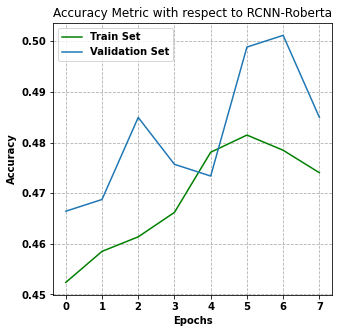

In [254]:
import matplotlib.pyplot as plt

plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.figure(figsize = (5,5))
plt.grid(linestyle = 'dashed')
plt.plot(history.history['accuracy'][:], c = 'green')
plt.plot(history.history['val_accuracy'][:])
plt.title('Accuracy Metric with respect to RCNN-Roberta')
plt.legend(['Train Set', 'Validation Set'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')


In [255]:
model.save('sentiment_model2')

INFO:tensorflow:Assets written to: sentiment_model2\assets


INFO:tensorflow:Assets written to: sentiment_model2\assets


# load and predict

In [1]:
import tensorflow as tf
import numpy as np 
import pandas as pd
from tqdm import tqdm

In [2]:
model = tf.keras.models.load_model('sentiment_model2')

In [3]:
e = model.layers[2]
weights = e.get_weights()[0]
weights.shape

(28996, 768)

In [4]:
from transformers import BertTokenizer

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [28]:
history = model.fit(train_ds, validation_data=val_ds, epochs=1, callbacks=[history])

479/479 [==============================] - 311s 624ms/step - loss: 1.1788 - accuracy: 0.4883 - val_loss: 1.1619 - val_accuracy: 0.4965


In [29]:
def prep_data(text):
    tokens = tokenizer(text, max_length=32, truncation=True, padding='max_length', add_special_tokens=True, return_tensors='tf')
    
    return ({'input_ids': tokens['input_ids'], 'attention_mask': tokens['attention_mask']})

In [34]:
probs = model.predict(prep_data('this movie was normal'))[0]
np.argmax(probs)

2

In [35]:
probs

array([0.03293058, 0.3231346 , 0.5083725 , 0.12130233, 0.01426002],
      dtype=float32)

In [231]:
pd.set_option('display.max_colwidth', None)

In [232]:
df = pd.read_csv('test.tsv', sep='\t')
df.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine effort .
1,156062,8545,An intermittently pleasing but mostly routine effort
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [233]:
df

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine effort .
1,156062,8545,An intermittently pleasing but mostly routine effort
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine
...,...,...,...
66287,222348,11855,"A long-winded , predictable scenario ."
66288,222349,11855,"A long-winded , predictable scenario"
66289,222350,11855,"A long-winded ,"
66290,222351,11855,A long-winded


In [234]:
df = df.drop_duplicates(subset=['SentenceId'], keep='first')
df.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine effort .
15,156076,8546,"Kidman is really the only thing that 's worth watching in Birthday Girl , a film by the stage-trained Jez Butterworth -LRB- Mojo -RRB- that serves as yet another example of the sad decline of British comedies in the post-Full Monty world ."
93,156154,8547,Once you get into its rhythm ... the movie becomes a heady experience .
117,156178,8548,I kept wishing I was watching a documentary about the wartime Navajos and what they accomplished instead of all this specious Hollywood hoo-ha .
158,156219,8549,"Kinnear does n't aim for our sympathy , but rather delivers a performance of striking skill and depth ."


In [235]:
df

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine effort .
15,156076,8546,"Kidman is really the only thing that 's worth watching in Birthday Girl , a film by the stage-trained Jez Butterworth -LRB- Mojo -RRB- that serves as yet another example of the sad decline of British comedies in the post-Full Monty world ."
93,156154,8547,Once you get into its rhythm ... the movie becomes a heady experience .
117,156178,8548,I kept wishing I was watching a documentary about the wartime Navajos and what they accomplished instead of all this specious Hollywood hoo-ha .
158,156219,8549,"Kinnear does n't aim for our sympathy , but rather delivers a performance of striking skill and depth ."
...,...,...,...
66220,222281,11851,Not sweet enough to liven up its predictable story and will leave even fans of hip-hop sorely disappointed .
66239,222300,11852,"Nasty , ugly , pointless and depressing , even if you hate clowns ."
66253,222314,11853,"With tightly organized efficiency , numerous flashbacks and a constant edge of tension , Miller 's film is one of 2002 's involvingly adult surprises ."
66280,222341,11854,They should have called it Gutterball .


In [236]:
df['Sentiment'] = None

C:\Users\LEGION\AppData\Local\Temp/ipykernel_13400/4098549540.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sentiment'] = None


In [237]:
for i, row in df.iterrows():
    tokens = prep_data(row['Phrase'])
    probs = model.predict(tokens)
    pred = np.argmax(probs)
    df.at[i, 'Sentiment'] = pred

In [238]:
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,156061,8545,An intermittently pleasing but mostly routine effort .,3
15,156076,8546,"Kidman is really the only thing that 's worth watching in Birthday Girl , a film by the stage-trained Jez Butterworth -LRB- Mojo -RRB- that serves as yet another example of the sad decline of British comedies in the post-Full Monty world .",3
93,156154,8547,Once you get into its rhythm ... the movie becomes a heady experience .,4
117,156178,8548,I kept wishing I was watching a documentary about the wartime Navajos and what they accomplished instead of all this specious Hollywood hoo-ha .,1
158,156219,8549,"Kinnear does n't aim for our sympathy , but rather delivers a performance of striking skill and depth .",3


In [239]:
df.tail()

,PhraseId,SentenceId,Phrase,Sentiment
66220,222281,11851,Not sweet enough to liven up its predictable story and will leave even fans of hip-hop sorely disappointed .,1
66239,222300,11852,"Nasty , ugly , pointless and depressing , even if you hate clowns .",0
66253,222314,11853,"With tightly organized efficiency , numerous flashbacks and a constant edge of tension , Miller 's film is one of 2002 's involvingly adult surprises .",3
66280,222341,11854,They should have called it Gutterball .,1
66287,222348,11855,"A long-winded , predictable scenario .",1


In [240]:
df.to_csv('./predicted-test.csv')